In [36]:
#get MNIST data
#first import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import gzip
import tensorflow as tf
from skimage.transform import downscale_local_mean
import scipy.stats
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import  mnist
from sklearn.metrics import accuracy_score




In [27]:
#get the data from keras
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print('X_train: ' + str(X_train.shape)) #60000 observations, 28 x 28 matrices
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape)) 
print('Y_test:  '  + str(y_test.shape))


X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [4]:
X_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

  0%|          | 0/2 [00:00<?, ?it/s]

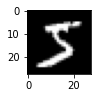

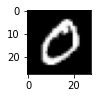

100%|██████████| 2/2 [00:00<00:00, 18.64it/s]


In [5]:
from matplotlib import pyplot
#take a look at a couple of the images for fun
for i in tqdm(range(2)):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

In [6]:
factors = (2,2) #2x2 blocks 

#initialize downscaled 3dimensional array
X_train_ds = list()
#for each image in the training data set, downscale by calculating the local mean of each 2x2 block and create a new 14x14 image
for i in range(len(X_train)):
    #downscale the bih
    ith_downscaled_image = downscale_local_mean(X_train[i], factors, cval=0, clip=True)
    
    #append it to downscaled training data
    X_train_ds.append(ith_downscaled_image)
    
#make it a 3 d array
X_train_ds = np.array(X_train_ds)

In [7]:
X_train_ds.shape #seems to have worked, X_train_ds is the downscaled version, each element is a 14 by 14 matrix

#for using in (the EM) algorithm, each sample should be treated as a vector (14x14 = 196 dimensional vector)
X_train_vectorized = X_train_ds.reshape(60000,196)

In [39]:
#for our purposes we only want to consider image 5 image classes: {0,1,2,3,4}
#drop the rest


#find the indices from y_train that are 5,6,7,8,9
bool_arr = (y_train >= 5) #find the indices of the images we don't want to cluster/consider
drop_indices = np.where(bool_arr)

#delete them from y_train
y_train_0_4 = np.delete(y_train, drop_indices)

#delete them from X_train as well
X_train_vectorized_0_4 = np.delete(X_train_vectorized, drop_indices, axis = 0) #drop the correct indices row-wise (axis = 0)
#remember, each row now corresponds to an image

In [10]:
X_train_vectorized_0_4_normalized = X_train_vectorized_0_4*(1/255)

In [11]:
X_train_vectorized_0_4_normalized[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.33039216, 0.89803922, 0.68431373, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00980392, 0.33137255, 0.96568627,
       0.92647059, 0.80490196, 0.42941176, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.44313725, 0.99019608, 0.79313725, 0.96568627,
       0.40294118, 0.82647059, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.24607

In [15]:
def logsumexp(x):
    c = x.max()
    return c + np.log(np.sum(np.exp(x - c)))

**EM Algorithm**

In [16]:
#Assume 5 clusters/classes
def em(data, k: int = 5, max_iter = 10, spherical = False, seed = 42, threshold = .0001):

    '''
    'data' is the dataset being clustered
    'k" is the number of classes we are assuming for the latent variable
    'max_iter' is the number of iterations for the EM algorithm to run    
    '''
    ###### INITIALIZATION
    np.random.seed(seed)
    #first initialize the maw fuckas
    n,p = data.shape #number of rows (n), number of columns (p)
    mus = np.random.rand(k,p) #need k mu vectors each of size p (196)
    class_probs = np.ones(k)*(1/k) #initialize with equal probability weights
    
    #same initialization of sigma for both diagonal and spherical gaussian mixtures
    sigmas = np.array([np.eye(p)*2 for _ in range(k)])

    #store the log likelihoods:
    log_likelihoods = [0]


    #initialize empty responsibilities matrix
    log_responsibilities = np.zeros(shape = (n,k)) #each observation/row/image should have k probs associated with it (representing prob it belongs to the jth class)
    f_ij = np.zeros(shape = (n,k))
    #iterate 
    for iteration in tqdm(range(max_iter)):

        ######## E-Step
        for j in range(k):
            log_responsibilities[:,j] = scipy.stats.multivariate_normal(mean = mus[j], cov=sigmas[j]).logpdf(data) + np.log(class_probs[j])
           
        
        #use logexpsum to convert rows to probabilities (rows sum to 1)
        for i in range(len(data)):
            f_ij[i,:] = np.exp(log_responsibilities[i,:] - round(logsumexp(log_responsibilities[i,:]),8))


        #column sums of the f_ij matrix, will be used frequently in the M -step
        f_j = np.sum(f_ij, axis = 0) #i think i've basically summed over i here for each j... so this is SUMi=1 to N 


        #### M-Step

        #update class probabilities
    
        class_probs = f_j/n

        #update mus (all k of them)
        for j in range(k):
            mus[j] = np.nan_to_num(np.sum(data * f_ij[:, j].reshape(len(data),1), axis=0)) / f_j[j]
        

        #spherical or gaussian
        if spherical == True:
            
            #list for storing the k sigma squared values
            sigma_squareds = []  

            for j in range(k):
                numerator_j = 0

                for i in range(n): #ith observation of the jth column matrix in f_ij x (ith row vec - jth mean vec)^T (ith row vec - jth mean vec)
                    numerator_j += f_ij[i,j] * (data[i,:] - mus[j] ).T @ (data[i,:] - mus[j])
                
                #after loop over all the observations for a given j, divide by p * f_j (the jth column mean of f_ij) and append to list
                sigma_squared_j = numerator_j / (p*f_j[j])
                sigma_squareds.append(sigma_squared_j)

            #create the sigma matrices and re-assign to the initial ones
            sigmas = np.array([np.eye(p)*sigma_squareds[i] for i in range(k)])        

        #gaussian
        else:
            for j in range(k):

                numerator_matrix_j = np.zeros(shape = (p,p)) #gonna add the matrices u get in the next loop iteratively to this

                for i in range(n):
                    
                    numerator_matrix_j += f_ij[i,j] * (data[i,:] - mus[j]).reshape(p,1) @ ((data[i,:] - mus[j]).reshape(p,1)).T

                sigma_j = numerator_matrix_j / (f_j[j])
                
                #assign the new sigma_j to the sigmas list
                sigmas[j] = sigma_j + np.eye(p)*.05
                    

        row_likelihoods = []
        ll = (np.array([np.log(class_probs[j]) + scipy.stats.multivariate_normal(mean = mus[j], cov = sigmas[j]).logpdf(data) for j in range(k)])).T
        row_likelihoods.append(logsumexp(ll[i,:]))
        log_likelihood = sum(row_likelihoods)
        print("log-likelihood: {} at iteration {:3f}".format(log_likelihood, iteration ))

        #append the log_likelihoods to the list
        log_likelihoods.append(log_likelihood)
        if np.abs(log_likelihood - log_likelihoods[-2]) < threshold:
            break



    return class_probs, mus, sigmas, log_responsibilities,f_ij, sigma_squareds,ll,log_likelihoods
        


In [ ]:
returned_class_probs, returned_mus, returned_sigmas,ret_log_responsibilities,ret_f_ij, returned_sigmas,ll, log_likelihoods = em(X_train_vectorized_0_4,k = 5,max_iter = 20, spherical = True)

In [40]:
predictions = np.argmax(ret_f_ij,axis=1) #get the index of the column 

#calculate accuracy
accuracy_score(y_true = y_train_0_4, y_pred = predictions)

0.3762910184337822

array([[1.00000000e+000, 7.97908576e-280, 1.62253204e-049,
        4.88501339e-307, 2.58759641e-047],
       [8.05316066e-043, 9.28508424e-206, 9.99999996e-001,
        1.35701303e-208, 8.20217106e-024],
       [1.17450504e-111, 1.00000000e+000, 5.41331937e-066,
        4.55481013e-165, 8.16598566e-068],
       ...,
       [7.25607818e-037, 6.55019443e-161, 9.99999999e-001,
        1.21157957e-201, 1.74816916e-032],
       [3.65530294e-073, 9.99999997e-001, 1.43702733e-027,
        4.41453614e-081, 5.59706235e-035],
       [3.56476217e-034, 2.72381786e-171, 2.12449664e-020,
        1.17234436e-193, 1.00000000e+000]])

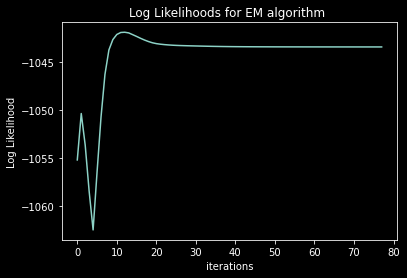

In [32]:
#plot log
from matplotlib import style
style.use('dark_background')
plt.figure()
plt.plot(np.arange(0, len(log_likelihoods[1:])), log_likelihoods[1:]) ## fix
plt.title("Log Likelihoods for EM algorithm ")
plt.xlabel("iterations")
plt.ylabel("Log Likelihood")
plt.show()